In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict, Counter
from tqdm import tqdm
# nltk
from nltk.stem import WordNetLemmatizer
#import emoji
#nltk.download('omw-1.4')
from textwrap import wrap
from wordcloud import WordCloud
import re
import string
import time
import os

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from pytorch_lightning import seed_everything
from datasets import list_datasets, load_dataset
import transformers
from transformers import BertModel, BertTokenizer, DistilBertTokenizer, DistilBertModel,DistilBertForSequenceClassification, get_linear_schedule_with_warmup

/home/peterstat1325/anaconda3/envs/fedpro/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 1000
seed_everything(seed)

Global seed set to 1000


1000

## Load Sentiment140 from hugginface

In [17]:
datasets = load_dataset('sentiment140')

Found cached dataset sentiment140 (/home/peterstat1325/.cache/huggingface/datasets/sentiment140/sentiment140/1.0.0/f81c014152931b776735658d8ae493b181927de002e706c4d5244ecb26376997)
100% 2/2 [00:00<00:00, 115.50it/s]


## Data label cleaning

In [18]:
'''train label'''
train_full_label = np.array(datasets['train']['sentiment'])
train_full_label = np.where(train_full_label==4,1,0)

'''train text'''
train_full_raw = np.array(datasets['train']['text'])
print('train length', len(train_full_label), len(train_full_raw))

'''train class counts'''
train_class = Counter(train_full_label)
train_class

train length 1600000 1600000


Counter({0: 800000, 1: 800000})

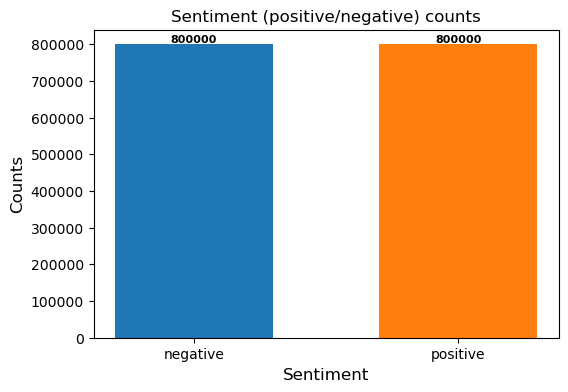

In [6]:
classnames = ['negative', 'positive']
cnt_list =  [train_class[0], train_class[1]]
fig, ax_prc = plt.subplots(figsize=(6,4))
ax_prc.bar(classnames,cnt_list, width=0.6, color=mcolors.TABLEAU_COLORS)
ax_prc.set_title('Sentiment (positive/negative) counts', fontsize=12)
ax_prc.set_ylabel('Counts', fontsize=12)
ax_prc.set_xlabel('Sentiment', fontsize=12)
#ax_prc.set_xticklabels(mth_name, fontsize=12, rotation=0)
for i, rows in enumerate(cnt_list):
    ax_prc.annotate(int(rows), xy=(i, rows+5000), ha='center', fontweight='bold', fontsize=8)

In [19]:
'''test label'''
test_label = np.array(datasets['test']['sentiment'])
neutral_idx = np.where(test_label==2)[0]
test_label = np.delete(test_label, neutral_idx)
test_label = np.where(test_label==4,1,0)

'''test text'''
test_raw = np.array(datasets['test']['text'])
test_raw = np.delete(test_raw, neutral_idx)
print('test length:', len(test_label), len(test_raw))

'''train class counts'''
test_class = Counter(test_label)
test_class

test length: 359 359


Counter({1: 182, 0: 177})

## Data preprocessing

In [20]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [21]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    pop_index = []
    for i, tweet in enumerate(textdata):
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' ', tweet)     #User   
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern,' ', tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
        #remove extra white spaces
        tweet = re.sub(r'\s+', ' ', tweet).strip()
        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            if word not in stopwordlist:
                if len(word)>1:
                    # Lemmatizing the word.
                    word = wordLemm.lemmatize(word)
                    tweetwords += (word+' ')
        if len(tweetwords) > 1:       
            processedText.append(tweetwords)
        else:
            pop_index.append(i)
    return processedText, pop_index

### Use 1.6M data, no 359 test set

In [8]:
start = time.time()
#preprocessing
full_arr, full_pop = preprocess(train_full_raw)

#pop index in label
full_label = np.delete(train_full_label, full_pop)

print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-start)} seconds')

Text Preprocessing complete.
Time Taken: 127 seconds


In [9]:
train_full_arr, test_arr, train_full_label, test_label = train_test_split(full_arr, full_label, test_size=0.2, random_state=seed)
train_arr, val_arr, train_label, val_label = train_test_split(full_arr, full_label, test_size=0.1, random_state=seed)

print('training set size:', len(train_label))
print('validation set size:', len(val_label))
print('testing set size:', len(test_label))

training set size: 1433663
validation set size: 159296
testing set size: 318592


## Original use full data

In [22]:
start = time.time()
#preprocessing
test_arr, test_pop = preprocess(test_raw)
train_full_arr, train_full_pop = preprocess(train_full_raw)

#pop index in label
train_full_label = np.delete(train_full_label, train_full_pop)
test_label = np.delete(test_label, test_pop)

print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-start)} seconds')

Text Preprocessing complete.
Time Taken: 127 seconds


In [23]:
train_full_arr[208]

'think want read book but library doesn '

In [30]:
for i, sent in enumerate(train_full_arr):
    if sent == ' ':
        print(i)

In [25]:
train_arr, val_arr, train_label, val_label = train_test_split(train_full_arr, train_full_label, test_size=0.1, random_state=seed)

print('training set size:', len(train_label))
print('validation set size:', len(val_label))
print('testing set size:', len(test_label))

training set size: 1433663
validation set size: 159296
testing set size: 359


## Convert to dataframe

In [26]:
train_df = pd.DataFrame(np.array([train_arr, train_label], dtype=object).T, columns=['text','label'])
val_df = pd.DataFrame(np.array([val_arr, val_label], dtype=object).T, columns=['text','label'])
test_df = pd.DataFrame(np.array([test_arr, test_label], dtype=object).T, columns=['text','label'])

In [27]:
list(train_df['text'][100:120])

['nope but love go ',
 'don know cause never stay ',
 'thumb ',
 'weird back make miss much ',
 'fix hair please de emoized ',
 'raining ',
 'hopefully one day get 24 hour without fsckign anything ',
 'ok fareal gnite morning muah ',
 'possible get signed photo big fan ',
 'guessin really dismissed ',
 'homework ',
 'well produce stand sold strawberry watermelon left chili pepper almost gone cucumber gone fresh produce cheap ',
 'get 100 follower day using URL add everyone train pay vip ',
 'guess email not site cant help ',
 'farewell party graduating class 2009 postponed ',
 'well duh ',
 'soon jam session brother got guitar lesson til end august ',
 'tired one show left entire college career ',
 'wish price right came sunday ',
 'don every wish love way ']

In [28]:
data_path = './dataset/'
#output to csv
os.makedirs(data_path, exist_ok=True)
train_df.to_csv(os.path.join(data_path,'train.csv'), index=False)
val_df.to_csv(os.path.join(data_path,'val.csv'), index=False)
test_df.to_csv(os.path.join(data_path,'test.csv'), index=False)

# Read CSV

In [3]:
data_path = './dataset/'
train_df = pd.read_csv(os.path.join(data_path,'train.csv'), encoding='ISO-8859-1')
val_df = pd.read_csv(os.path.join(data_path,'val.csv'), encoding='ISO-8859-1')
test_df = pd.read_csv(os.path.join(data_path,'test.csv'), encoding='ISO-8859-1')
train_df

,text,label
0,good luck wit guess,0
1,whats bad abt good thing indeed congrats summit,1
2,bbq beer cold sun shining char amp jim potteri...,1
3,don quot justify quot unfollow but since made ...,1
4,iplt20 website dousing lot cricket fan interest,0
...,...,...
1433658,need massage neck hurt 800 1700 go ughh,0
1433659,URL think guy kind telling talk time cant cont...,0
1433660,extemely saddened sudden death favorite aunt m...,0
1433661,URL chillin wit pooch,1


## TFIDF

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

'''Create torch dataset'''
X_train, y_train = train_df['text'], train_df['label']
X_val, y_val = val_df['text'], val_df['label']
X_test, y_test = test_df['text'], test_df['label']
'''TFIDF vectorization'''
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=1000)
vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train).toarray().astype(np.float32)
X_val = vectorizer.transform(X_val).toarray().astype(np.float32)
X_test = vectorizer.transform(X_test).toarray().astype(np.float32)

In [9]:
np.save(os.path.join(data_path, 'X_train'), X_train)
np.save(os.path.join(data_path, 'X_val'), X_val)
np.save(os.path.join(data_path, 'X_test'), X_test)

## Wordcloud

### Positive sentiment

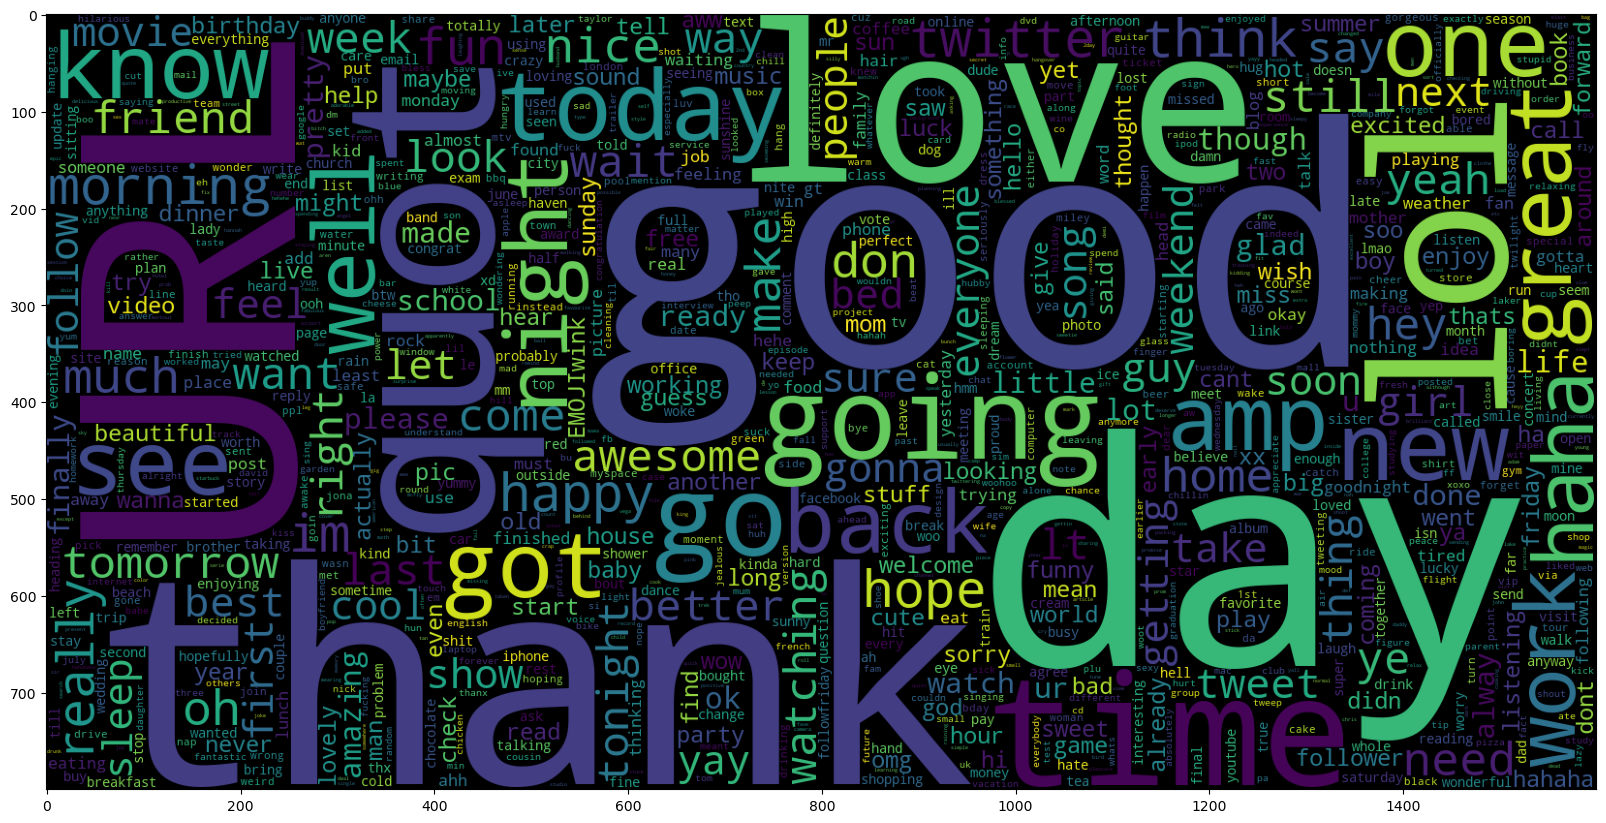

In [13]:
data_pos = train_df[train_df['label']==1]['text']
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_pos))
plt.imshow(wc)

### Negative sentiment

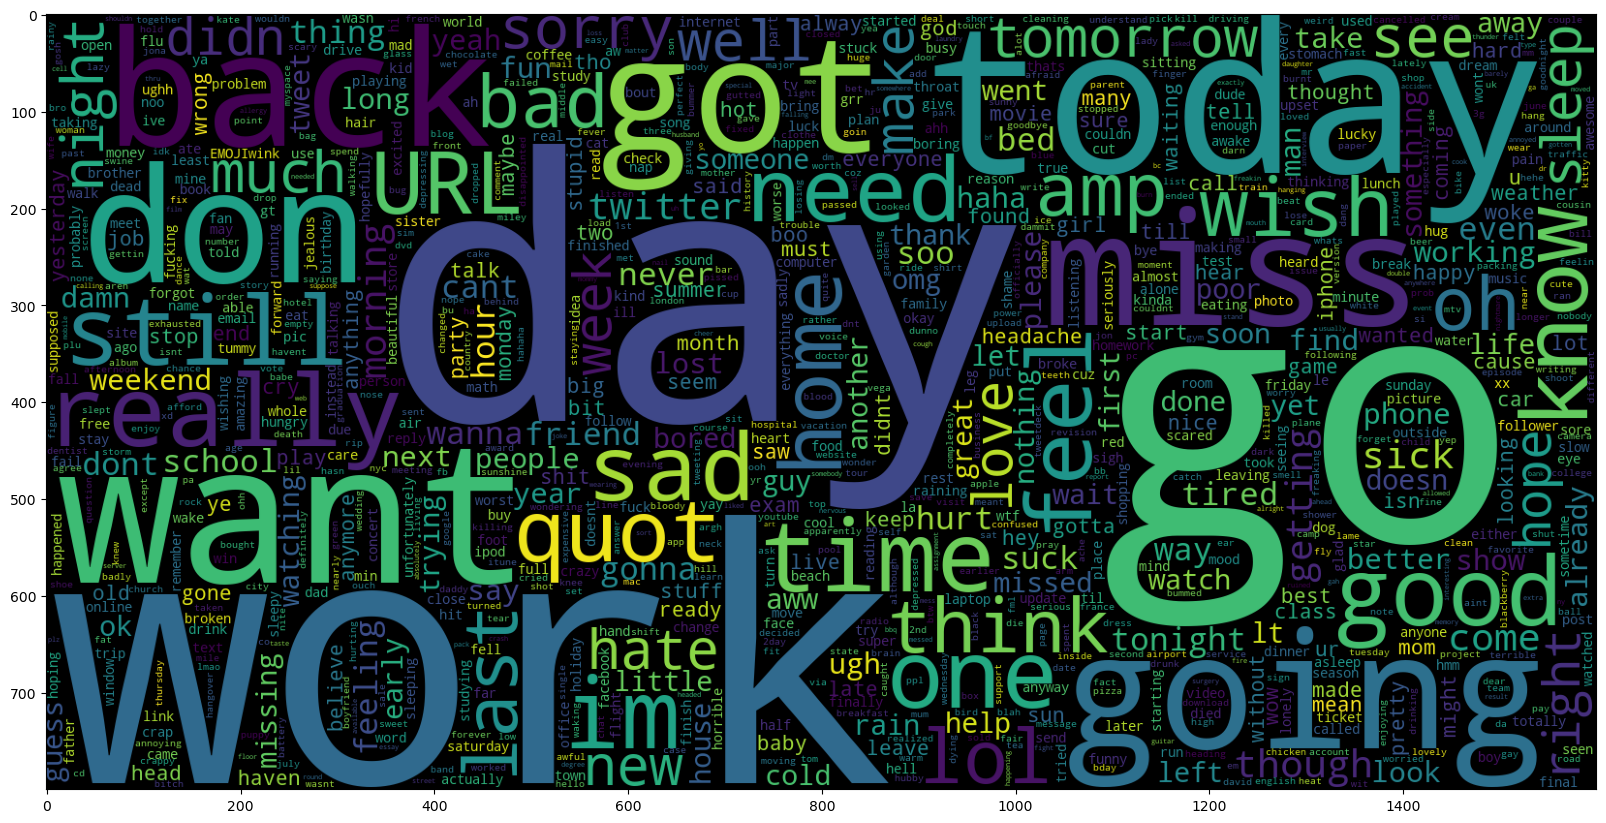

In [14]:
data_neg = train_df[train_df['label']==0]['text']
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

## BERT-base/ DistilBERT-base

In [4]:
#model_name = 'bert-base-uncased'
#tokenizer = BertTokenizer.from_pretrained(model_name)

model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

### Sample text

In [6]:
sample_txt = 'Hello, I am Olu Mel from Hawaii and I like to play the ukulele.'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: Hello, I am Olu Mel from Hawaii and I like to play the ukulele.
   Tokens: ['hello', ',', 'i', 'am', 'ol', '##u', 'mel', 'from', 'hawaii', 'and', 'i', 'like', 'to', 'play', 'the', 'uk', '##ule', '##le', '.']
Token IDs: [7592, 1010, 1045, 2572, 19330, 2226, 11463, 2013, 7359, 1998, 1045, 2066, 2000, 2377, 1996, 2866, 9307, 2571, 1012]


In [11]:
print(tokenizer.sep_token, tokenizer.sep_token_id)
print(tokenizer.cls_token, tokenizer.cls_token_id)
print(tokenizer.pad_token, tokenizer.pad_token_id)
print(tokenizer.unk_token, tokenizer.unk_token_id)

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


In [7]:
import warnings
warnings.filterwarnings('ignore')

encoding = tokenizer.encode_plus(
    sample_txt,
    truncation=True,
    max_length=256, #64, 128, 256
    add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors="pt",  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [21]:
print(len(encoding['input_ids'][0]))
print(encoding['input_ids'][0][:20])
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])[:20])

256
tensor([  101,  7592,  1010,  1045,  2572, 19330,  2226, 11463,  2013,  7359,
         1998,  1045,  2066,  2000,  2377,  1996,  2866,  9307,  2571,  1012])
['[CLS]', 'hello', ',', 'i', 'am', 'ol', '##u', 'mel', 'from', 'hawaii', 'and', 'i', 'like', 'to', 'play', 'the', 'uk', '##ule', '##le', '.']


## Configuration

In [7]:
config = {'exp_name': 'ce_cln_0617',
          'epochs': 5, #10, 30
          'n_classes': 1,
          'batch_size': 16, #16
          'max_len': 128, #256
          'lr': 1e-5,
          'loss_fn': 'BCE',
          'n_workers': 2,
          'seed': seed,
          }

In [20]:
train_df['text']

0          what watching in the local news made me realiz...
1          glad your friend had fun apo it wa awesome fo ...
2                          you wont be able to see the show 
3                             miss watching the panic dance 
4                                   greeting amp salutation 
                                 ...                        
1439995    cleaning my room packing but ugg my ankle is k...
1439996    grocery trip ton of awesome fresh food and ice...
1439997    the boy is paying for his bay to breaker shirt...
1439998    episode 57 of live is set to release tomorrow ...
1439999      good behind the scene technical type of person 
Name: text, Length: 1440000, dtype: object

## Create Dataset

In [8]:
class TwitterDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, item):
        text = self.df.text[item]
        label = self.df.label[item]

        encoding = self.tokenizer.encode_plus(
            text, #w/o .item()
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            # padding="longest",    
            pad_to_max_length=True,
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors="pt",
        )

        return {
            "text": text,
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(label, dtype=torch.float),
        }

In [26]:
train_ds.__getitem__(1044)

{'text': 'morning everyone just lost my job what now ',
 'input_ids': tensor([ 101, 2851, 3071, 2074, 2439, 2026, 3105, 2054, 2085,  102,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,

In [9]:
train_ds = TwitterDataset(train_df, tokenizer, config['max_len'])
val_ds = TwitterDataset(val_df, tokenizer, config['max_len'])
test_ds = TwitterDataset(test_df, tokenizer, config['max_len'])

'''dataloader'''
train_loader = DataLoader(train_ds, config['batch_size'], num_workers=config['n_workers'])
val_loader = DataLoader(val_ds, config['batch_size'], num_workers=config['n_workers'])
test_loader = DataLoader(test_ds, config['batch_size'], num_workers=config['n_workers'])

## Model

In [26]:
class DistilBERT_Sent(nn.Module):

    def __init__(self, n_classes):
        super(DistilBERT_Sent, self).__init__()
        
        self.dbert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = nn.Linear(768, 768)
        self.classifier = nn.Linear(768, n_classes)
        self.dropout = nn.Dropout(0.2)
        

    def forward(self, input_ids, attention_mask):
        
        outs = self.dbert(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )
            
        hidden_state = outs[0]  # (bs, seq_len, dim)
        pooled_output = hidden_state[:, 0]  # (bs, dim)
        pooled_output = self.pre_classifier(pooled_output)  # (bs, dim)
        pooled_output = nn.ReLU()(pooled_output)  # (bs, dim)
        pooled_output = self.dropout(pooled_output)  # (bs, dim)
        logits = self.classifier(pooled_output)  # (bs, num_labels)
        
        return logits

In [10]:
class BERT_Sent(nn.Module):

    def __init__(self, n_classes):
        super(BERT_Sent, self).__init__()
        
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        output = self.drop(outs["pooler_output"])
        return self.out(output)

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"

#model = BERT_Sent(config['n_classes']).to(device)
model = DistilBERT_Sent(config['n_classes']).to(device)

optimizer = Adam(model.parameters(), lr=config['lr'], weight_decay=1e-5)
total_steps = len(train_loader)*config['epochs']
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

if config['loss_fn'] == 'BCE':
    criterion = nn.BCEWithLogitsLoss().to(device)
if config['loss_fn'] == 'gam_logit_loss':
    criterion = gamma_logit_loss().to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
model

DistilBERT_Sent(
  (dbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear

In [28]:
train_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total trainable parameters: {train_params}')

Total trainable parameters: 66954241
